# Fast Neural Style Transfer

In [1]:
from collections import namedtuple
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook

from transformer_net import TransformerNet
from utils import gram_matrix

%matplotlib inline

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = "coco/"
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                normalize])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()
if torch.cuda.is_available():
    transformer.cuda()

In [6]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [7]:
vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
del vgg_model

In [8]:
def recover_image(img):
    return (
        (img * 
       np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) + 
       np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))).transpose(0, 2, 3, 1) * 255.
    ).clip(0, 255).astype(np.uint8)

In [9]:
STYLE_IMAGE = "style_images/mosaic.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
style_img_tensor = transforms.Compose([transforms.ToTensor(),
                            normalize])(style_img).unsqueeze(0)
# assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
if torch.cuda.is_available():
    style_img_tensor = style_img_tensor.cuda()

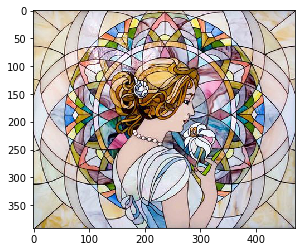

In [10]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

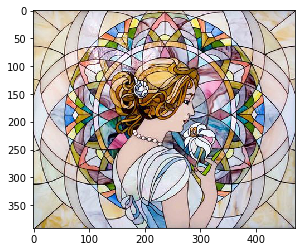

In [11]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

In [12]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
style_loss_features = loss_network(Variable(style_img_tensor, volatile=True))
gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features]

In [13]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [14]:
np.mean(gram_style[3].data.cpu().numpy())

0.035839673

In [15]:
np.mean(style_loss_features[0].data.cpu().numpy())

0.90219593

In [16]:
gram_style[0].numel()

4096

In [17]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 3
LOG_INTERVAL = 200
REGULARIZATION = 1e-7

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)

for _ in range(2):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = Variable(x)
        if torch.cuda.is_available():
            x = x.cuda()

        y = transformer(x)
        xc = Variable(x.data, volatile=True)

        features_y = loss_network(y)
        features_xc = loss_network(xc)

        f_xc_c = Variable(features_xc[1].data, requires_grad=False)

        content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        agg_reg_loss += reg_loss.data[0]

        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0

Widget Javascript not detected.  It may not be installed or enabled properly.


Thu Jul 27 01:14:12 2017 [800/82783] content: 12.533923  style: 14.338450  reg: 0.052899  total: 26.925272
Thu Jul 27 01:15:25 2017 [1600/82783] content: 11.940644  style: 4.320121  reg: 0.060271  total: 16.321035
Thu Jul 27 01:16:39 2017 [2400/82783] content: 10.961073  style: 3.416462  reg: 0.060052  total: 14.437587
Thu Jul 27 01:17:53 2017 [3200/82783] content: 10.377488  style: 2.977914  reg: 0.059812  total: 13.415215
Thu Jul 27 01:19:06 2017 [4000/82783] content: 9.964763  style: 2.828613  reg: 0.059818  total: 12.853193
Thu Jul 27 01:20:20 2017 [4800/82783] content: 9.747665  style: 2.762309  reg: 0.060126  total: 12.570101
Thu Jul 27 01:21:34 2017 [5600/82783] content: 9.501259  style: 2.619470  reg: 0.060271  total: 12.181000
Thu Jul 27 01:22:48 2017 [6400/82783] content: 9.297592  style: 2.637683  reg: 0.060172  total: 11.995448
Thu Jul 27 01:24:02 2017 [7200/82783] content: 9.156057  style: 2.577341  reg: 0.060325  total: 11.793723
Thu Jul 27 01:25:16 2017 [8000/82783] cont

Thu Jul 27 02:49:08 2017 [62400/82783] content: 7.854114  style: 2.161577  reg: 0.065528  total: 10.081219
Thu Jul 27 02:50:22 2017 [63200/82783] content: 7.799076  style: 2.177432  reg: 0.065329  total: 10.041836
Thu Jul 27 02:51:36 2017 [64000/82783] content: 7.885072  style: 2.166043  reg: 0.065371  total: 10.116485
Thu Jul 27 02:52:50 2017 [64800/82783] content: 7.831019  style: 2.169695  reg: 0.065649  total: 10.066363
Thu Jul 27 02:54:04 2017 [65600/82783] content: 7.776549  style: 2.182757  reg: 0.065403  total: 10.024709
Thu Jul 27 02:55:18 2017 [66400/82783] content: 7.797624  style: 2.154296  reg: 0.065807  total: 10.017727
Thu Jul 27 02:56:32 2017 [67200/82783] content: 7.926260  style: 2.163613  reg: 0.066036  total: 10.155910
Thu Jul 27 02:57:46 2017 [68000/82783] content: 7.856838  style: 2.174709  reg: 0.066207  total: 10.097755
Thu Jul 27 02:59:00 2017 [68800/82783] content: 7.824600  style: 2.157605  reg: 0.066237  total: 10.048442
Thu Jul 27 03:00:14 2017 [69600/82783

Widget Javascript not detected.  It may not be installed or enabled properly.


Thu Jul 27 03:21:48 2017 [83583/82783] content: 11.458777  style: 3.168484  reg: 0.099189  total: 14.726451
Thu Jul 27 03:23:03 2017 [84383/82783] content: 7.714449  style: 2.116014  reg: 0.067143  total: 9.897607
Thu Jul 27 03:24:17 2017 [85183/82783] content: 7.804230  style: 2.136538  reg: 0.067103  total: 10.007870
Thu Jul 27 03:25:31 2017 [85983/82783] content: 7.805349  style: 2.114103  reg: 0.067172  total: 9.986624
Thu Jul 27 03:26:45 2017 [86783/82783] content: 7.753817  style: 2.115209  reg: 0.067303  total: 9.936329
Thu Jul 27 03:27:59 2017 [87583/82783] content: 7.752473  style: 2.108419  reg: 0.067269  total: 9.928161
Thu Jul 27 03:29:13 2017 [88383/82783] content: 7.768551  style: 2.127763  reg: 0.067415  total: 9.963730
Thu Jul 27 03:30:27 2017 [89183/82783] content: 7.824330  style: 2.107927  reg: 0.067636  total: 9.999892
Thu Jul 27 03:31:41 2017 [89983/82783] content: 7.722797  style: 2.128472  reg: 0.067460  total: 9.918730
Thu Jul 27 03:32:55 2017 [90783/82783] cont

Thu Jul 27 04:56:52 2017 [145183/82783] content: 7.648912  style: 2.065405  reg: 0.069505  total: 9.783823
Thu Jul 27 04:58:06 2017 [145983/82783] content: 7.695919  style: 2.068830  reg: 0.069513  total: 9.834262
Thu Jul 27 04:59:20 2017 [146783/82783] content: 7.597822  style: 2.050876  reg: 0.069392  total: 9.718090
Thu Jul 27 05:00:34 2017 [147583/82783] content: 7.720032  style: 2.069468  reg: 0.069431  total: 9.858930
Thu Jul 27 05:01:48 2017 [148383/82783] content: 7.680240  style: 2.075315  reg: 0.069586  total: 9.825142
Thu Jul 27 05:03:02 2017 [149183/82783] content: 7.676445  style: 2.060389  reg: 0.069362  total: 9.806195
Thu Jul 27 05:04:16 2017 [149983/82783] content: 7.587605  style: 2.044871  reg: 0.069639  total: 9.702115
Thu Jul 27 05:05:30 2017 [150783/82783] content: 7.650609  style: 2.061697  reg: 0.069411  total: 9.781718
Thu Jul 27 05:06:44 2017 [151583/82783] content: 7.661975  style: 2.073122  reg: 0.069696  total: 9.804794
Thu Jul 27 05:07:58 2017 [152383/8278

In [29]:
img = y.data.cpu().numpy()
img = recover_image(img).clip(0, 200)
print(img.shape)

(3, 256, 256, 3)


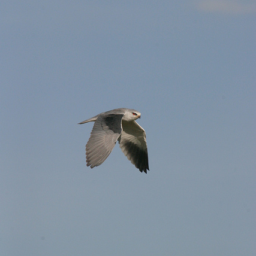

In [35]:
Image.fromarray(recover_image(x.data.cpu().numpy())[0])

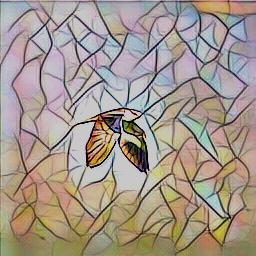

In [34]:
Image.fromarray(img[0])

In [33]:
output_img = Image.fromarray(img[0])
output_img.save("debug.png")

In [23]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

82783

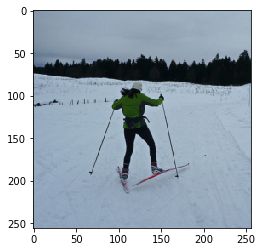

In [24]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                normalize])
img_tensor = transform(img)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True).unsqueeze(0))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

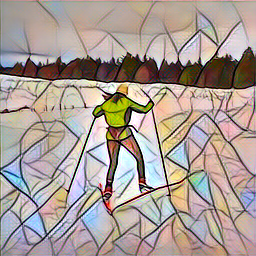

In [36]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

In [26]:
save_model_path = "model_mosaic.pth"
torch.save(transformer.state_dict(), save_model_path)

In [39]:
transformer.load_state_dict(torch.load(save_model_path))

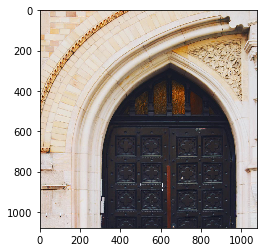

In [42]:
img = Image.open("content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([transforms.ToTensor(),
                                normalize])
img_tensor = transform(img)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True).unsqueeze(0))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

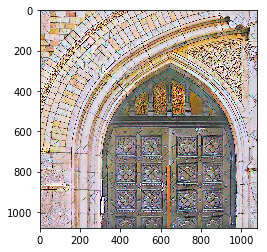

In [44]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [45]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")